# Identifying the Area of Interest

In this notebook we define the area of interest for our mobility studies. We export this area in GeoJSON format and its associated regular grid in the `output` folder.

## Preamble

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import geopandas as gpd

%matplotlib inline
sns.set(context='notebook', font='Fira Sans', style='white', palette='plasma')

## Barcelona Metropolitan Area

We obtained the list of _municipis_ (municipalities) from [Wikipedia](https://en.wikipedia.org/wiki/%C3%80rea_Metropolitana_de_Barcelona):

In [2]:
municipis = '''Barcelona 
L'Hospitalet de Llobregat 
Badalona 
Santa Coloma de Gramenet 
Cornellà de Llobregat 
Sant Boi de Llobregat 
Sant Cugat del Vallès 
El Prat de Llobregat 
Viladecans 
Castelldefels 
Cerdanyola del Vallès 
Esplugues de Llobregat 
Gavà 
Sant Feliu de Llobregat 
Ripollet 
Sant Adrià de Besòs 
Montcada i Reixac 
Sant Joan Despí 
Barberà del Vallès 
Sant Vicenç dels Horts 
Sant Andreu de la Barca 
Molins de Rei 
Sant Just Desvern 
Badia del Vallès 
Corbera de Llobregat 
Castellbisbal 
Pallejà 
Montgat 
Cervelló 
Santa Coloma de Cervelló 
Tiana 
Begues 
Torrelles de Llobregat 
El Papiol 
Sant Climent de Llobregat 
La Palma de Cervelló 
'''.strip().split('\n')

municipis

['Barcelona ',
 "L'Hospitalet de Llobregat ",
 'Badalona ',
 'Santa Coloma de Gramenet ',
 'Cornellà de Llobregat ',
 'Sant Boi de Llobregat ',
 'Sant Cugat del Vallès ',
 'El Prat de Llobregat ',
 'Viladecans ',
 'Castelldefels ',
 'Cerdanyola del Vallès ',
 'Esplugues de Llobregat ',
 'Gavà ',
 'Sant Feliu de Llobregat ',
 'Ripollet ',
 'Sant Adrià de Besòs ',
 'Montcada i Reixac ',
 'Sant Joan Despí ',
 'Barberà del Vallès ',
 'Sant Vicenç dels Horts ',
 'Sant Andreu de la Barca ',
 'Molins de Rei ',
 'Sant Just Desvern ',
 'Badia del Vallès ',
 'Corbera de Llobregat ',
 'Castellbisbal ',
 'Pallejà ',
 'Montgat ',
 'Cervelló ',
 'Santa Coloma de Cervelló ',
 'Tiana ',
 'Begues ',
 'Torrelles de Llobregat ',
 'El Papiol ',
 'Sant Climent de Llobregat ',
 'La Palma de Cervelló']

In [3]:
amb = ox.gdf_from_places(municipis)

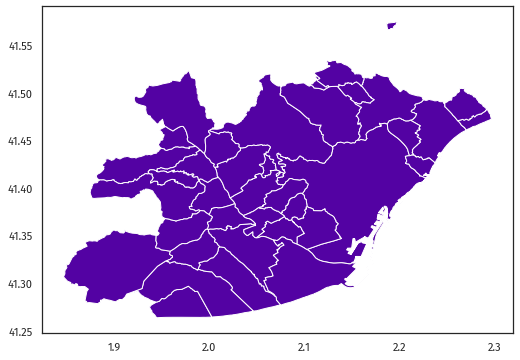

In [4]:
amb.plot(figsize=(16, 6), edgecolor='white', linewidth=1)

In [5]:
bbox = amb.total_bounds
bbox

array([ 1.8467312, 41.263409 ,  2.2964971, 41.5749847])

## Grid Analysis

We will analyze movement in a regular square grid. The [S2](https://s2geometry.io/) system defines a grid with several sizes (levels). We use level 14, where each cell has an edge length of around 500 meters.

In [6]:
import s2sphere

r = s2sphere.RegionCoverer()
r.min_level = 14
r.max_level = 14
p1 = s2sphere.LatLng.from_degrees(bbox[1], bbox[0])
p2 = s2sphere.LatLng.from_degrees(bbox[3], bbox[2])
cell_ids = r.get_covering(s2sphere.LatLngRect.from_point_pair(p1, p2))
print(len(cell_ids))

5827


This code converts the internal S2 representation into a GeoJSON representation, which can be used in other systems.

In [7]:
def s2geojson(cellids):
    fc = {
      "type": "FeatureCollection"
    }

    features = []

    for cid in cellids:
        pt_feature = {
          "type": "Feature",
          "properties": {},
          "geometry": {
            "type": "Polygon"
          }
        }
        cell = s2sphere.Cell(cid)
        vertices = [s2sphere.LatLng.from_point(cell.get_vertex(v)) for v in range(4)]
        vertices = [[v.lng().degrees, v.lat().degrees] for v in vertices]
        pt_feature['geometry']['coordinates'] = [vertices]#[float(s) for s in str(latlong).split()[-1].split(',')
        pt_feature['properties']['s2_cellid'] = cid.id()

        features.append(pt_feature)

    fc['features'] = features

    return fc

In [8]:
grid = s2geojson(cell_ids)

With this code we can load the grid using `geopandas`:

In [9]:
from io import BytesIO
import json

In [10]:
gdf = gpd.read_file(BytesIO(json.dumps(grid).encode('utf-8')))

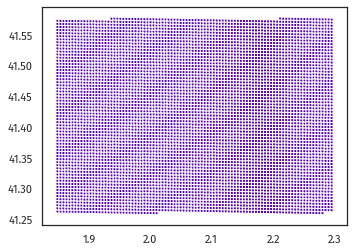

In [11]:
gdf.plot()

In [12]:
grid_amb = gpd.sjoin(gdf, amb[['geometry',]], op='intersects', how='inner')

/home/egraells/miniconda3/envs/iotwins_foursquare/lib/python3.8/site-packages/geopandas/tools/sjoin.py:58: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs)
  warn(


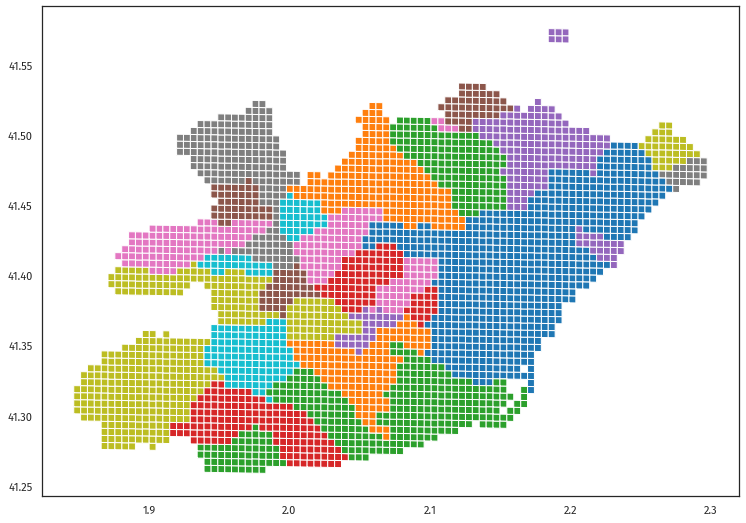

In [13]:
grid_amb.plot(column='index_right', categorical=True, legend=False, figsize=(20, 9))

Let's export the data for use in the next notebook.

In [14]:
amb.to_file('output/relevant_area.geo.json', driver='GeoJSON')

In [15]:
grid_amb.to_file('output/relevant_grid.geo.json', driver='GeoJSON')